# Using Zillow Housing Data to Forecast Home Values in Washington State

#### By Salome Grasland
#### 04/13/2023

In [1]:
#importing necessary packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from sklearn.metrics import mean_squared_error as MSE
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from collections import Counter
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Business Understanding
Our client Steady has had great success with their sustainable housing community in King County, WA. They are looking to build a new community elsewhere in the state of Washington. They want the community to be affordable to first time home owners so they are looking at the best zip codes to invest in with homes that are 500,000 USD or less in value. 

## The Problem 
Steady, a housing development agency, is unsure of where they want to build their next housing community. It has to be in the state of Washington and affordable to first time home owners, so home values need to be 500,000 USD or less. 

## The Solution 
Data from April 1996 to April 2018 from Zillow was used to build a time series model. The model was used to forecast the best zip codes to build in. 

### Metric: ROI
The metric used is return on investment. The top 5 zip codes with the best average 3 year ROI were isolated. Models were trained on the zipcode with the highest ROI and the model was used to forecast which top 3 zip codes would have the best ROI for the next year. 


# Data Understanding

#### Zillow Housing Data

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow. The data was originally created by Zillow and obtained on Kaggle for the purpose of this project. 

Each row represents a unique home and its location and value. Each record contains location info, such as, city, zipcode, and metro and median housing sales prices for each month.

The dates will be used as the index value for doing time series analysis on monthly housing prices for the span April 1996 to April 2018. 

There are 14,723 rows and 272 variables:

- **RegionID**: Unique index, 58196 through 753844   
- **RegionName**: Unique Zip Code, 1001 through 99901   
- **City**: City in which the zip code is located    
- **State**: State in which the zip code is located     
- **Metro**: Metropolitan Area in which the zip code is located      
- **CountyName**: County in which the zip code is located       
- **SizeRank**: Numerical rank of size of zip code, ranked 1 through 14723       
- **1996-04 through 2018-04**: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code  
- **Value**: refers to the median housing price



In [2]:
#opening time series data
df = pd.read_csv('zillow_data.csv')
#taking a peep at what it looks like 
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

# Data Exploration and Scrubbing

## Exploring the Data

In [3]:
#there are 14722 entries 
#272 columns 
#And 3 different data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
#the mean SizeRank is 7362 
#the mean house value in April 1996 was 118,299USD
#the mean house valie in April 2018 was 288,039USD
df.describe()

RegionID    RegionName      SizeRank       1996-04       1996-05  \
count   14723.000000  14723.000000  14723.000000  1.368400e+04  1.368400e+04   
mean    81075.010052  48222.348706   7362.000000  1.182991e+05  1.184190e+05   
std     31934.118525  29359.325439   4250.308342  8.600251e+04  8.615567e+04   
min     58196.000000   1001.000000      1.000000  1.130000e+04  1.150000e+04   
25%     67174.500000  22101.500000   3681.500000  6.880000e+04  6.890000e+04   
50%     78007.000000  46106.000000   7362.000000  9.950000e+04  9.950000e+04   
75%     90920.500000  75205.500000  11042.500000  1.432000e+05  1.433000e+05   
max    753844.000000  99901.000000  14723.000000  3.676700e+06  3.704200e+06   

            1996-06       1996-07       1996-08       1996-09       1996-10  \
count  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04   
mean   1.185374e+05  1.186531e+05  1.187803e+05  1.189275e+05  1.191205e+05   
std    8.630923e+04  8.646795e+04  8.665094e+04  8.687208e+04  8.715185e+04   
min    1.160000e+04  1.180000e+04  1.180000e+04  1.200000e+04  1.210000e+04   
25%    6.910000e+04  6.920000e+04  6.937500e+04  6.950000e+04  6.960000e+04   
50%    9.970000e+04  9.970000e+04  9.980000e+04  9.990000e+04  9.995000e+04   
75%    1.432250e+05  1.432250e+05  1.435000e+05  1.437000e+05  1.439000e+05   
max    3.729600e+06  3.754600e+06  3.781800e+06  3.813500e+06  3.849600e+06   

       ...       2017-07       2017-08       2017-09       2017-10  \
count  ...  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   ...  2.733354e+05  2.748658e+05  2.764646e+05  2.780332e+05   
std    ...  3.603984e+05  3.614678e+05  3.627563e+05  3.644610e+05   
min    ...  1.440000e+04  1.450000e+04  1.470000e+04  1.480000e+04   
25%    ...  1.269000e+05  1.275000e+05  1.282000e+05  1.287000e+05   
50%    ...  1.884000e+05  1.896000e+05  1.905000e+05  1.914000e+05   
75%    ...  3.050000e+05  3.066500e+05  3.085000e+05  3.098000e+05   
max    ...  1.888990e+07  1.870350e+07  1.860530e+07  1.856940e+07   

            2017-11       2017-12       2018-01       2018-02       2018-03  \
count  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   2.795209e+05  2.810953e+05  2.826571e+05  2.843687e+05  2.865114e+05   
std    3.656003e+05  3.670454e+05  3.695727e+05  3.717739e+05  3.724612e+05   
min    1.450000e+04  1.430000e+04  1.410000e+04  1.390000e+04  1.380000e+04   
25%    1.292500e+05  1.299000e+05  1.306000e+05  1.310500e+05  1.319500e+05   
50%    1.925000e+05  1.934000e+05  1.941000e+05  1.950000e+05  1.967000e+05   
75%    3.117000e+05  3.134000e+05  3.151000e+05  3.168500e+05  3.188500e+05   
max    1.842880e+07  1.830710e+07  1.836590e+07  1.853040e+07  1.833770e+07   

            2018-04  
count  1.472300e+04  
mean   2.880399e+05  
std    3.720544e+05  
min    1.380000e+04  
25%    1.324000e+05  
50%    1.981000e+05  
75%    3.211000e+05  
max    1.789490e+07  

[8 rows x 268 columns]

In [5]:
#Metro is missing values, they will need to be filled in later
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

### Exploring 'RegionID' 


In [6]:
#14723 unique values
#RegionID is just a unique identifier
#This column will be dropped later to reduce noise 
print(df.RegionID.value_counts())
print(df.RegionID.nunique())

84654    1
60802    1
58299    1
63186    1
77596    1
        ..
67309    1
72802    1
74730    1
72705    1
95851    1
Name: RegionID, Length: 14723, dtype: int64
14723


### Exploring 'Region Name' aka Zipcode


In [7]:
# Now look at RegionName, this is the zip code
df.RegionName.value_counts() 

60657    1
7764     1
1226     1
13624    1
45335    1
        ..
22556    1
33761    1
38242    1
33602    1
89155    1
Name: RegionName, Length: 14723, dtype: int64

In [8]:
#renaming to Zipcode
df = df.rename(columns={'RegionName':'Zipcode'})

In [9]:
#Change Zipcode dtype to 'str'
df[['Zipcode']] = df[['Zipcode']].astype('string')
df.dtypes

RegionID     int64
Zipcode     string
City        object
State       object
Metro       object
             ...  
2017-12      int64
2018-01      int64
2018-02      int64
2018-03      int64
2018-04      int64
Length: 272, dtype: object

### Exploring City


In [10]:
#There are 7554 unique values
df.City.nunique()

7554

### Exploring State 


In [11]:
#There are 51 states listed, including DC 
print(df.State.nunique())
print(df.State.unique())

51
['IL' 'TX' 'NY' 'CA' 'FL' 'TN' 'NC' 'GA' 'DC' 'MO' 'OK' 'AZ' 'NJ' 'MD'
 'VA' 'WA' 'OH' 'MI' 'MA' 'KS' 'NM' 'CT' 'NV' 'PA' 'CO' 'OR' 'IN' 'SC'
 'KY' 'AR' 'ND' 'MN' 'AL' 'DE' 'LA' 'MS' 'ID' 'MT' 'HI' 'WI' 'UT' 'ME'
 'SD' 'WV' 'IA' 'RI' 'NE' 'WY' 'AK' 'NH' 'VT']


### Exploring Metro 
There was only 1 missing value here, so it was filled with none. 

In [12]:
#There are 7554 unique values
df.Metro.nunique()

701

### Exploring County Name


In [13]:
#The top three counties are Los Angeles, Jefferson, and Orange
df.CountyName.value_counts()

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
              ... 
Uintah           1
Rains            1
Benewah          1
Pettis           1
Licking          1
Name: CountyName, Length: 1212, dtype: int64

### Exploring Size Rank 


In [14]:
#Size rank is the numerical rank of the size of the zip code. 
#Top three zipcodes in size are 60657 (Chicago, IL), 75070 (McKinney, TX), and 77494 (Katy, TX). 

df[['Zipcode', 'SizeRank']].sort_values(by=['SizeRank'])


Zipcode  SizeRank
0       60657         1
1       75070         2
2       77494         3
3       60614         4
4       79936         5
...       ...       ...
14718    1338     14719
14719    3293     14720
14720   40404     14721
14721   81225     14722
14722   89155     14723

[14723 rows x 2 columns]

## Limiting the Dataset

For this project our client is specifically interested in zipcodes in the state of Washington with a price ceiling of lower than 500,000USD

In [15]:
#selecting WA state zipcodes
df = df.loc[df['State']== 'WA'].reset_index()

#selecting homes valued at less than 500,000
df = df[df['2018-04']<=500000]

In [16]:
#dropping index, 'City, CountyName, State, and Metro
#similar information is already provided by zipcode
#and our dataset is now limited to WA state 
df.drop(['index', 'City', 'SizeRank', 'RegionID', 'CountyName', 'State', 'Metro'], axis=1, inplace=True)
df.head()

Zipcode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
3    99301   92400.0   91900.0   91400.0   91000.0   90400.0   89800.0   
5    98682  117700.0  118900.0  120400.0  122200.0  124200.0  126100.0   
7    99208  121200.0  120500.0  119700.0  119100.0  118400.0  117800.0   
9    98632  102400.0  102700.0  102900.0  103100.0  103200.0  103200.0   
10   98208  159100.0  158900.0  158900.0  158900.0  159200.0  159600.0   

     1996-10   1996-11   1996-12  ...  2017-07  2017-08  2017-09  2017-10  \
3    89300.0   89000.0   88700.0  ...   205400   207500   210100   212600   
5   127800.0  129300.0  130300.0  ...   286400   287800   289700   292600   
7   117400.0  117000.0  116800.0  ...   234900   237000   238300   238800   
9   103200.0  103100.0  103100.0  ...   192000   193900   196700   198400   
10  160100.0  160700.0  161500.0  ...   424700   428400   432500   436700   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
3    214200   216000   217600   218300   218100   217600  
5    295800   298200   300200   301900   303900   305200  
7    240400   243500   247000   249300   250800   251500  
9    198700   200400   203500   205400   211900   221500  
10   440500   446300   451600   457000   465400   472800  

[5 rows x 266 columns]

### Scrubbing Sale Values 
Sale values are missing from 2014-06 back. To deal with some missing values I will drop anything before 1998-04 so that the dataset spans exactly 20 years. Then any rows that are missing values will be dropped. I believe dropping the rows rather than filling in missing values with the mean is better in this instance because we want our data to remain accurate and it's less than 10% of the data. 

Later on in this notebook we will be limiting the data to span only the last five years. So the missing values before 2008-10 will not be as significant. 


In [17]:
#checking for missing values
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(df.isnull().sum())

Zipcode    0
1996-04    5
1996-05    5
1996-06    5
1996-07    5
1996-08    5
1996-09    5
1996-10    5
1996-11    5
1996-12    5
1997-01    5
1997-02    5
1997-03    5
1997-04    5
1997-05    5
1997-06    5
1997-07    5
1997-08    5
1997-09    5
1997-10    5
1997-11    5
1997-12    5
1998-01    5
1998-02    5
1998-03    5
1998-04    5
1998-05    5
1998-06    5
1998-07    5
1998-08    5
1998-09    5
1998-10    5
1998-11    5
1998-12    5
1999-01    5
1999-02    5
1999-03    5
1999-04    5
1999-05    5
1999-06    5
1999-07    5
1999-08    5
1999-09    5
1999-10    5
1999-11    5
1999-12    5
2000-01    5
2000-02    5
2000-03    5
2000-04    5
2000-05    5
2000-06    5
2000-07    5
2000-08    5
2000-09    5
2000-10    5
2000-11    5
2000-12    5
2001-01    5
2001-02    5
2001-03    5
2001-04    5
2001-05    5
2001-06    5
2001-07    5
2001-08    5
2001-09    5
2001-10    5
2001-11    5
2001-12    5
2002-01    5
2002-02    5
2002-03    5
2002-04    5
2002-05    5
2002-06    5
2002-07    5

In [18]:
#dropping any date column before April 1998
df.drop(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08','1996-09', '1996-10', '1996-11', '1996-12', '1997-01','1997-02','1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11','1997-12', '1998-01', '1998-02', '1998-03'], axis=1, inplace=True)
df.dropna()

Zipcode   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05  \
3     99301   85500.0   85000.0   84500.0   84100.0   83800.0   83800.0   84000.0   84300.0   84800.0   85700.0   86500.0   87200.0   87600.0   87700.0   87700.0   87800.0   88000.0   88300.0   88800.0   89400.0   90300.0   91500.0   92700.0   93700.0   94300.0   94500.0   94500.0   94300.0   93800.0   93200.0   92100.0   90600.0   88500.0   86300.0   84000.0   81500.0   79100.0   76900.0   75100.0   73800.0   72900.0   72500.0   72400.0   72500.0   73100.0   74100.0   75300.0   76500.0   77700.0   78900.0   80200.0   81600.0   83000.0   84200.0   85300.0   86400.0   86700.0   85300.0   83600.0   83500.0   85200.0   88400.0   92300.0   96400.0  100700.0  105100.0  109500.0  113400.0  116500.0  118700.0  119600.0  119200.0  118000.0  116600.0  115300.0  113900.0  112100.0  109600.0  107000.0  105000.0  104700.0  106800.0  111400.0  117700.0  124200.0  129600.0  133800.0  136700.0  139000.0  141000.0  143000.0  144900.0  146600.0  147800.0  148400.0  147800.0  146300.0  144500.0   
5     98682  131800.0  132100.0  132200.0  132300.0  132200.0  132100.0  132000.0  131900.0  131900.0  132200.0  132500.0  133000.0  133500.0  134000.0  134600.0  135200.0  135700.0  136300.0  136900.0  137500.0  138100.0  138800.0  139400.0  139900.0  140200.0  140400.0  140400.0  140300.0  140200.0  140200.0  140200.0  140300.0  140600.0  141100.0  141600.0  142100.0  142600.0  143100.0  143500.0  143900.0  144300.0  144700.0  145300.0  145800.0  146400.0  147100.0  147800.0  148300.0  148800.0  149100.0  149300.0  149500.0  149700.0  150000.0  150400.0  151000.0  151600.0  152300.0  152800.0  153200.0  153700.0  154300.0  155100.0  156100.0  157200.0  158300.0  159400.0  160500.0  161500.0  162600.0  163700.0  164900.0  166300.0  167700.0  169400.0  171100.0  172900.0  174800.0  176800.0  178900.0  181200.0  183600.0  186200.0  189100.0  192500.0  196200.0  200200.0  204600.0  209200.0  213600.0  218000.0  222000.0  225900.0  229500.0  232700.0  235900.0  239000.0  241500.0   
7     99208  115200.0  115100.0  115300.0  115600.0  116200.0  117000.0  117900.0  118900.0  119900.0  121000.0  122000.0  123000.0  123800.0  124300.0  124500.0  124400.0  124300.0  124200.0  124100.0  124200.0  124600.0  125300.0  126300.0  127200.0  127900.0  128300.0  128300.0  127800.0  127200.0  126300.0  125400.0  124700.0  124100.0  123900.0  124000.0  124400.0  124600.0  124900.0  125100.0  125400.0  125600.0  126000.0  126400.0  126900.0  127600.0  128500.0  129800.0  131100.0  132500.0  133600.0  134400.0  134800.0  135000.0  134900.0  134700.0  134900.0  134900.0  134300.0  132900.0  131800.0  131100.0  131300.0  132200.0  133600.0  135200.0  137000.0  138600.0  140000.0  141000.0  141800.0  142300.0  142300.0  142000.0  141500.0  141200.0  141500.0  142600.0  144600.0  147400.0  150500.0  153700.0  156700.0  159200.0  161400.0  163700.0  166600.0  170000.0  173900.0  177800.0  181300.0  184300.0  186700.0  188700.0  190700.0  192900.0  195400.0  198100.0  200600.0   
9     98632  113400.0  1

In [19]:
#mean value in April 1998 for state of Washington 
#is 130,400USD
#mean value in April 2008 for state of Washington 
#is 300,813USD
df.describe()

1998-04        1998-05        1998-06        1998-07        1998-08        1998-09        1998-10        1998-11        1998-12        1999-01        1999-02        1999-03        1999-04        1999-05        1999-06        1999-07        1999-08        1999-09        1999-10        1999-11        1999-12        2000-01        2000-02        2000-03        2000-04        2000-05        2000-06        2000-07        2000-08        2000-09        2000-10        2000-11        2000-12        2001-01        2001-02        2001-03        2001-04        2001-05        2001-06        2001-07        2001-08        2001-09        2001-10        2001-11        2001-12        2002-01        2002-02        2002-03        2002-04        2002-05        2002-06        2002-07        2002-08        2002-09        2002-10        2002-11        2002-12        2003-01        2003-02        2003-03        2003-04        2003-05        2003-06        2003-07        2003-08        2003-09  \
count     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     265.000000     267.000000     267.000000     267.000000   
mean   130400.377358  130896.981132  131357.358491  131778.113208  132177.358491  132556.603774  132943.018868  133330.943396  133784.528302  134292.075472  134779.245283  135192.830189  135581.509434  135949.056604  136298.867925  136642.264151  136997.735849  137393.207547  137847.547170  138356.226415  138969.811321  139670.943396  140367.169811  140972.075472  141512.830189  141976.226415  142353.962264  142663.018868  142939.245283  143202.641509  143493.207547  143833.584906  144260.377358  144785.660377  145350.188679  145869.056604  146344.528302  146772.452830  147161.132075  147530.943396  147913.584906  148342.264151  148846.792453  149419.245283  150098.113208  150862.641509  151653.584906  152376.226415  153005.660377  153538.490566  153976.226415  154358.867925  154738.867925  155158.490566  155631.320755  156345.660377  157216.603774  158021.886792  158713.584906  159444.528302  160213.962264  161063.018868  162009.811321  163093.632959  164166.666667  165290.636704   
std     34081.108134   34397.132411   34703.801215   34990.624992   35253.542921   35494.337520   35728.429050   35963.441363   36224.580773   36489.957801   36721.118101   36938.325768   37154.192400   37361.891249   37571.114875   37770.529569   37972.117893   38182.874740   38412.271206   38676.849441   38981.718641   39294.657391   39591.643037   39854.780585   40089.495355   40288.114846   40449.830427   40585.456866   40697.708215   40821.329473   40965.046435   41164.491313   41412.951511   41683.109430   41949.991083   42198.212221   42409.302267   42586.529067   42736.337072   42863.033548   42983.814391   43101.611209   43235.553717   43407.564269   43605.988480   43810.890966   43991.022633   44127.799947   44203.422735   44236.661549   44232.988522   44190.303923   44148.357397   44120.371823   44142.639407   44180.132203   44244.341658   44376.915795   44592.807168   44878.535337   45209.683125   45570.832211   45949.940420   46285.915913   46827.922609   47474.036695   
min     37900.000

## Exploring Return on Investments
Let's look at the 20 year, 10 year, 5 year, and 1 year ROI on each zip code in Washington. ROI is equal to the (current price - the original price/original)*100. 

Highest 20 year ROI: 230%  
Highest 10 year ROI: 66%   
Highest 5 year ROI: 115%   
Highest 1 year ROI: 35%    

It is expected that there will be a relationship between time and ROI. Typically real estate increases in value naturally with time, however, for some reason the return on investment for the 10 year ROI was lower than the 5 year ROI. This is most likely due to the 2008 housing crisis. If the housing crisis had not occurred we would expect the 10 year ROI to be around 180%. We will need to consider the impact of the 2008 housing crisis on our Time Series model. 


In [20]:
# Create 20 year, 10 year, 5 year, 3 year, and 1 year ROI 
#ROI is equal to the (current price - the original price/original)*100
df['20_yr_ROI'] = (df['2018-04'] - df['1998-04'])/(df['1998-04'])*100
df['10_yr_ROI'] = (df['2018-04'] - df['2008-04'])/(df['2008-04'])*100
df['5_yr_ROI'] = (df['2018-04'] - df['2013-04'])/(df['2013-04'])*100
df['1_yr_ROI'] = (df['2018-04'] - df['2017-04'])/(df['2017-04'])*100

### 20 Year ROI

#### Let's look at the zipcodes that had the highest 20 year ROI

In [21]:
#sorting by highest ROI
df.sort_values('20_yr_ROI',ascending=False).head()[['Zipcode','20_yr_ROI']]

Zipcode   20_yr_ROI
103   98146  230.040323
155   98043  220.094403
274   98359  215.767045
323   99181  211.345646
110   98405  203.303965

### 10 year ROI

#### Let's look at the zipcodes that had the highest 10 year ROI

In [22]:
#sorting by highest ROI
df.sort_values('10_yr_ROI',ascending=False).head()[['Zipcode','10_yr_ROI']]

Zipcode  10_yr_ROI
3     99301  66.871166
155   98043  50.746269
102   99337  48.781937
103   98146  47.035928
13    99336  46.987088

### 5 Year ROI

#### Let's look at the zipcodes that had the highest 5 year ROI

In [23]:
#sorting by highest ROI
df.sort_values('5_yr_ROI',ascending=False).head()[['Zipcode','5_yr_ROI']]

Zipcode    5_yr_ROI
77    98168  115.506849
155   98043  105.854293
103   98146  104.369538
278   98251  102.355316
259   98294  102.059202

### 1 Year ROI

#### Let's look at the zipcodes that had the highest 1 year ROI

In [24]:
#sorting by highest ROI
df.sort_values('1_yr_ROI',ascending=False).head()[['Zipcode','1_yr_ROI']]

Zipcode   1_yr_ROI
317   98568  35.667752
209   98550  29.835651
216   98611  25.567108
291   98570  24.351109
315   98356  24.025514

### Average one year ROI over the past 5 years 

The top 5 zipcodes with the highest average one year ROI over the past 5 years are:
- 98168 = 27.78%
- 98146 = 25.96%
- 98043 = 25.77%
- 98294 = 25.35%
- 98251 = 25.20%

In [25]:
# Let's look at the ROI from 2018, 2017, 2016, 2015, 2014 
# And average the 5 values together 
df['2017_ROI'] = (df['2017-04'] - df['2016-04'])/(df['2016-04'])*100 
df['2016_ROI'] = (df['2016-04'] - df['2015-04'])/(df['2015-04'])*100
df['2015_ROI'] = (df['2015-04'] - df['2014-04'])/(df['2014-04'])*100
df['2014_ROI'] = (df['2014-04'] - df['2013-04'])/(df['2013-04'])*100
df['avg_1_yr_ROI'] = ((df['1_yr_ROI'] + df['2017_ROI'] + df['2016_ROI'] + df['2015_ROI'] + df['2014_ROI'])/3)
df.drop(['2017_ROI', '2016_ROI', '2015_ROI', '2014_ROI'], axis=1, inplace=True)

df.head()

Zipcode   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05  \
3    99301   85500.0   85000.0   84500.0   84100.0   83800.0   83800.0   84000.0   84300.0   84800.0   85700.0   86500.0   87200.0   87600.0   87700.0   87700.0   87800.0   88000.0   88300.0   88800.0   89400.0   90300.0   91500.0   92700.0   93700.0   94300.0   94500.0   94500.0   94300.0   93800.0   93200.0   92100.0   90600.0   88500.0   86300.0   84000.0   81500.0   79100.0   76900.0   75100.0   73800.0   72900.0   72500.0   72400.0   72500.0   73100.0   74100.0   75300.0   76500.0   77700.0   78900.0   80200.0   81600.0   83000.0   84200.0   85300.0   86400.0   86700.0   85300.0   83600.0   83500.0   85200.0   88400.0   92300.0   96400.0  100700.0  105100.0  109500.0  113400.0  116500.0  118700.0  119600.0  119200.0  118000.0  116600.0  115300.0  113900.0  112100.0  109600.0  107000.0  105000.0  104700.0  106800.0  111400.0  117700.0  124200.0  129600.0  133800.0  136700.0  139000.0  141000.0  143000.0  144900.0  146600.0  147800.0  148400.0  147800.0  146300.0  144500.0   
5    98682  131800.0  132100.0  132200.0  132300.0  132200.0  132100.0  132000.0  131900.0  131900.0  132200.0  132500.0  133000.0  133500.0  134000.0  134600.0  135200.0  135700.0  136300.0  136900.0  137500.0  138100.0  138800.0  139400.0  139900.0  140200.0  140400.0  140400.0  140300.0  140200.0  140200.0  140200.0  140300.0  140600.0  141100.0  141600.0  142100.0  142600.0  143100.0  143500.0  143900.0  144300.0  144700.0  145300.0  145800.0  146400.0  147100.0  147800.0  148300.0  148800.0  149100.0  149300.0  149500.0  149700.0  150000.0  150400.0  151000.0  151600.0  152300.0  152800.0  153200.0  153700.0  154300.0  155100.0  156100.0  157200.0  158300.0  159400.0  160500.0  161500.0  162600.0  163700.0  164900.0  166300.0  167700.0  169400.0  171100.0  172900.0  174800.0  176800.0  178900.0  181200.0  183600.0  186200.0  189100.0  192500.0  196200.0  200200.0  204600.0  209200.0  213600.0  218000.0  222000.0  225900.0  229500.0  232700.0  235900.0  239000.0  241500.0   
7    99208  115200.0  115100.0  115300.0  115600.0  116200.0  117000.0  117900.0  118900.0  119900.0  121000.0  122000.0  123000.0  123800.0  124300.0  124500.0  124400.0  124300.0  124200.0  124100.0  124200.0  124600.0  125300.0  126300.0  127200.0  127900.0  128300.0  128300.0  127800.0  127200.0  126300.0  125400.0  124700.0  124100.0  123900.0  124000.0  124400.0  124600.0  124900.0  125100.0  125400.0  125600.0  126000.0  126400.0  126900.0  127600.0  128500.0  129800.0  131100.0  132500.0  133600.0  134400.0  134800.0  135000.0  134900.0  134700.0  134900.0  134900.0  134300.0  132900.0  131800.0  131100.0  131300.0  132200.0  133600.0  135200.0  137000.0  138600.0  140000.0  141000.0  141800.0  142300.0  142300.0  142000.0  141500.0  141200.0  141500.0  142600.0  144600.0  147400.0  150500.0  153700.0  156700.0  159200.0  161400.0  163700.0  166600.0  170000.0  173900.0  177800.0  181300.0  184300.0  186700.0  188700.0  190700.0  192900.0  195400.0  198100.0  200600.0   
9    98632  113400.0  11280

In [26]:
#sorting top zipcodes by average ROI value over the last 5 years
ROI = df.sort_values('avg_1_yr_ROI',ascending=False).head(10)[['Zipcode','avg_1_yr_ROI']]
print(ROI)

    Zipcode  avg_1_yr_ROI
77    98168     27.782655
155   98043     25.962773
103   98146     25.778959
278   98251     25.359544
259   98294     25.208993
144   98178     24.498135
74    98201     24.136108
224   98252     24.017441
213   98148     23.269849
285   98237     23.258674


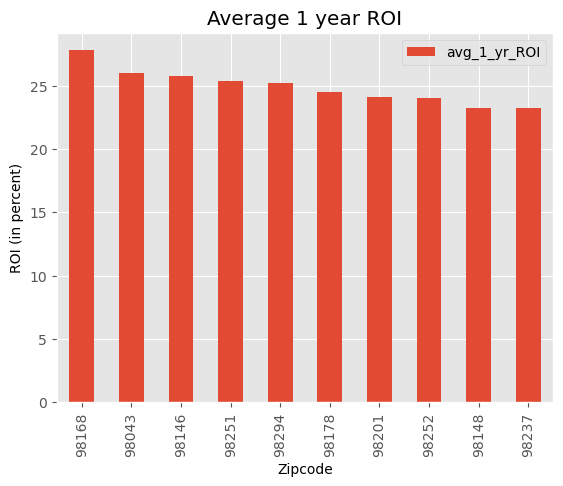

In [27]:
ROI.plot(y = 'avg_1_yr_ROI', x = 'Zipcode', kind = 'bar', title= 'Average 1 year ROI', ylabel = 'ROI (in percent)');

In [28]:
#creating a dataframe that contains the top 5 zipcodes 
df.drop(df[df['avg_1_yr_ROI'] <= 25].index, inplace = True)
df.head()

Zipcode   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05  \
77    98168  132300.0  133400.0  134400.0  135500.0  136500.0  137600.0  138600.0  139700.0  140800.0  141900.0  142900.0  143900.0  144800.0  145700.0  146600.0  147600.0  148700.0  149800.0  151100.0  152400.0  154000.0  155600.0  157200.0  158700.0  160200.0  161700.0  163100.0  164300.0  165500.0  166500.0  167400.0  168400.0  169200.0  170000.0  170700.0  171200.0  171600.0  171900.0  172200.0  172500.0  172800.0  173200.0  173800.0  174600.0  175500.0  176400.0  177500.0  178500.0  179400.0  180300.0  181100.0  181900.0  182800.0  183700.0  184800.0  186000.0  187100.0  188200.0  189200.0  190200.0  191200.0  192200.0  193300.0  194400.0  195600.0  196800.0  198200.0  199500.0  200800.0  202300.0  204000.0  205700.0  207600.0  209700.0  212100.0  214700.0  217400.0  220200.0  223000.0  225800.0  228700.0  231600.0  234300.0  237000.0  240000.0  243300.0  246800.0  250500.0  254200.0  257800.0  261100.0  264100.0  267100.0  270300.0  273500.0  276900.0  280600.0  284300.0   
103   98146  148800.0  150100.0  151400.0  152800.0  154200.0  155500.0  157000.0  158400.0  159900.0  161500.0  163000.0  164400.0  165900.0  167300.0  168800.0  170300.0  171900.0  173500.0  175200.0  177000.0  178800.0  180700.0  182500.0  184100.0  185600.0  186900.0  188100.0  189300.0  190300.0  191400.0  192400.0  193400.0  194400.0  195500.0  196500.0  197400.0  198000.0  198500.0  198900.0  199300.0  199700.0  200000.0  200400.0  200800.0  201300.0  202000.0  202800.0  203600.0  204400.0  205200.0  206100.0  207200.0  208400.0  209700.0  211200.0  213000.0  214900.0  216300.0  217300.0  218500.0  219900.0  221400.0  222900.0  224300.0  225700.0  227000.0  228300.0  229700.0  231400.0  233400.0  235500.0  237700.0  240000.0  242400.0  245000.0  247600.0  250300.0  253100.0  256100.0  259100.0  262100.0  265200.0  268200.0  271400.0  274800.0  278500.0  282700.0  287400.0  292100.0  296800.0  301200.0  305400.0  309400.0  313200.0  316800.0  320600.0  324800.0  329000.0   
155   98043  148300.0  149800.0  151200.0  152700.0  154200.0  155600.0  157100.0  158600.0  160100.0  161600.0  162900.0  164100.0  165200.0  166300.0  167300.0  168200.0  169100.0  170000.0  171000.0  172000.0  173000.0  174000.0  175000.0  175700.0  176400.0  177100.0  177700.0  178300.0  178900.0  179600.0  180300.0  181100.0  181900.0  182700.0  183500.0  184200.0  184800.0  185300.0  185800.0  186300.0  186800.0  187400.0  188100.0  189000.0  189900.0  190900.0  191800.0  192700.0  193500.0  194300.0  195100.0  195900.0  196900.0  198000.0  199400.0  200800.0  202500.0  204200.0  206000.0  207900.0  209700.0  211300.0  212600.0  213600.0  214300.0  214900.0  215300.0  215700.0  216300.0  217000.0  217900.0  218900.0  220200.0  221800.0  223800.0  226100.0  228700.0  231600.0  234700.0  237800.0  241100.0  244200.0  247100.0  249900.0  252900.0  256100.0  259300.0  262700.0  265900.0  269100.0  272000.0  274600.0  277200.0  279800.0  282300.0  285400.0  289300.0  293700.0   
259   98294  141800.0  1

In [29]:
#The top 5 zipcodes are 98168, 98146, 98043, 98294, 98251
zipcode = df['Zipcode'].unique()
print(zipcode)

<StringArray>
['98168', '98146', '98043', '98294', '98251']
Length: 5, dtype: string


In [30]:
#Dropping all ROI columns
df.drop(['20_yr_ROI', '10_yr_ROI', '5_yr_ROI', '1_yr_ROI', 'avg_1_yr_ROI'], axis=1, inplace=True)
df.head()

Zipcode   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05  \
77    98168  132300.0  133400.0  134400.0  135500.0  136500.0  137600.0  138600.0  139700.0  140800.0  141900.0  142900.0  143900.0  144800.0  145700.0  146600.0  147600.0  148700.0  149800.0  151100.0  152400.0  154000.0  155600.0  157200.0  158700.0  160200.0  161700.0  163100.0  164300.0  165500.0  166500.0  167400.0  168400.0  169200.0  170000.0  170700.0  171200.0  171600.0  171900.0  172200.0  172500.0  172800.0  173200.0  173800.0  174600.0  175500.0  176400.0  177500.0  178500.0  179400.0  180300.0  181100.0  181900.0  182800.0  183700.0  184800.0  186000.0  187100.0  188200.0  189200.0  190200.0  191200.0  192200.0  193300.0  194400.0  195600.0  196800.0  198200.0  199500.0  200800.0  202300.0  204000.0  205700.0  207600.0  209700.0  212100.0  214700.0  217400.0  220200.0  223000.0  225800.0  228700.0  231600.0  234300.0  237000.0  240000.0  243300.0  246800.0  250500.0  254200.0  257800.0  261100.0  264100.0  267100.0  270300.0  273500.0  276900.0  280600.0  284300.0   
103   98146  148800.0  150100.0  151400.0  152800.0  154200.0  155500.0  157000.0  158400.0  159900.0  161500.0  163000.0  164400.0  165900.0  167300.0  168800.0  170300.0  171900.0  173500.0  175200.0  177000.0  178800.0  180700.0  182500.0  184100.0  185600.0  186900.0  188100.0  189300.0  190300.0  191400.0  192400.0  193400.0  194400.0  195500.0  196500.0  197400.0  198000.0  198500.0  198900.0  199300.0  199700.0  200000.0  200400.0  200800.0  201300.0  202000.0  202800.0  203600.0  204400.0  205200.0  206100.0  207200.0  208400.0  209700.0  211200.0  213000.0  214900.0  216300.0  217300.0  218500.0  219900.0  221400.0  222900.0  224300.0  225700.0  227000.0  228300.0  229700.0  231400.0  233400.0  235500.0  237700.0  240000.0  242400.0  245000.0  247600.0  250300.0  253100.0  256100.0  259100.0  262100.0  265200.0  268200.0  271400.0  274800.0  278500.0  282700.0  287400.0  292100.0  296800.0  301200.0  305400.0  309400.0  313200.0  316800.0  320600.0  324800.0  329000.0   
155   98043  148300.0  149800.0  151200.0  152700.0  154200.0  155600.0  157100.0  158600.0  160100.0  161600.0  162900.0  164100.0  165200.0  166300.0  167300.0  168200.0  169100.0  170000.0  171000.0  172000.0  173000.0  174000.0  175000.0  175700.0  176400.0  177100.0  177700.0  178300.0  178900.0  179600.0  180300.0  181100.0  181900.0  182700.0  183500.0  184200.0  184800.0  185300.0  185800.0  186300.0  186800.0  187400.0  188100.0  189000.0  189900.0  190900.0  191800.0  192700.0  193500.0  194300.0  195100.0  195900.0  196900.0  198000.0  199400.0  200800.0  202500.0  204200.0  206000.0  207900.0  209700.0  211300.0  212600.0  213600.0  214300.0  214900.0  215300.0  215700.0  216300.0  217000.0  217900.0  218900.0  220200.0  221800.0  223800.0  226100.0  228700.0  231600.0  234700.0  237800.0  241100.0  244200.0  247100.0  249900.0  252900.0  256100.0  259300.0  262700.0  265900.0  269100.0  272000.0  274600.0  277200.0  279800.0  282300.0  285400.0  289300.0  293700.0   
259   98294  141800.0  1

## Date Indexing 
When working with time series data in Python it is helpful to have the dates in the index. We will be modifying the dataset to have the dates indexed. 

In [31]:
#creating function to melt data
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [32]:
#running function on dataset
df = melt_data(df)
df.head()

Zipcode       Date     value
0   98168 1998-04-01  132300.0
1   98146 1998-04-01  148800.0
2   98043 1998-04-01  148300.0
3   98294 1998-04-01  141800.0
4   98251 1998-04-01  128300.0

In [33]:
#Change Zipcode dtype to 'str'
df['Zipcode'] = df['Zipcode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%y')

# Set the 'Date' column as index
df.set_index('Date', inplace=True)

In [34]:
#checking dataframe was indexed correctly 
df.head()

Zipcode     value
Date                        
1998-04-01   98168  132300.0
1998-04-01   98146  148800.0
1998-04-01   98043  148300.0
1998-04-01   98294  141800.0
1998-04-01   98251  128300.0

#### Time-series Index Slicing for Data Selection

Given the 2008 Housing Bubble precedent, I have decided to slice the dates and start my analysis in April 2013. As we can see from the plot below around 2013 is when home prices start increasing again and displaying more normal behavior. This leaves us with a 10 year time window.




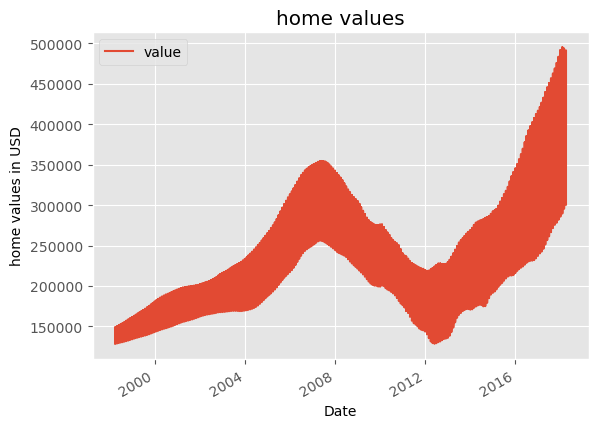

In [35]:
#plotting home value against time
df.plot(y='value', kind = 'line', title = 'home values', ylabel= 'home values in USD');

In [36]:
#limiting the dataset to the most recent 5 years to account for the skew due to the recession
df = df['2013-04-01':]

#### Resampling
- Let's group the data bucket into 1 months basis   
- Get the monthly average by calling the .mean() method  

In [37]:
df.resample('MS').mean().index

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'], dtype='datetime64[ns]', name='Date', freq='MS')

### Exploring Home Value

In [38]:
#the average value for a home 
#over the last five years is 279,235USD
#the minimum is 148,600USD
#the maximum is 495,200USD
#this is expected because we capped the value at 500,000USD
df.describe()

value
count     305.000000
mean   279235.081967
std     82045.059720
min    148600.000000
25%    216000.000000
50%    267000.000000
75%    324700.000000
max    495200.000000

In [39]:
#Plotting home values to visually inspect 
#Q1 = 217,675USD
#Q3 = 320,725USD
import plotly.express as px
fig = px.box(df, y='value', points="all", title = 'home values')
fig.show()

In [40]:
#removing outliers from sale value
q_low = df["value"].quantile(0.01)
q_hi  = df["value"].quantile(0.99)

df = df[(df["value"] < q_hi) & (df["value"] > q_low)]
df.describe()

value
count     297.000000
mean   278034.343434
std     78007.689973
min    160700.000000
25%    218000.000000
50%    267000.000000
75%    320100.000000
max    483400.000000

In [41]:
#assuring that there are no missing values 
df.isna().sum()

Zipcode    0
value      0
dtype: int64

In [42]:
# Perform backward filling of missing values
df = df.bfill()

# Find the total number of missing values in the time series
df.isna().sum()

Zipcode    0
value      0
dtype: int64

### Top 5 Zipcode Analysis
The top 5 zip codes with the highest average one year ROI over the past 5 years are:
- 98168 = 27.78%
- 98146 = 25.96%
- 98043 = 25.77%
- 98294 = 25.35%
- 98251 = 25.20%

Let's visualize each of our top zip codes and run a Dickey-Fuller test. This is a statistical test that tests for stationarity. Our null hypothesis in this case is that the time series is not stationary. So if the test statistic result is less than the critical value then the null hypothesis can be rejected and we can say the series is stationary. 

We can also see from our previous plot that all the zipcodes express an upward linear trend. We will need to attempt to detrend the series by differencing the data. Differencing can be used to remove a series dependence on time. It is performed by subtracting the previous observation from the current observation. 


In [43]:
#creating a dataframe that contains just zipcode and value
df_zip = df[['Zipcode', 'value']]
df_zip.tail()

Zipcode     value
Date                        
2018-03-01   98251  295500.0
2018-04-01   98168  393300.0
2018-04-01   98043  474700.0
2018-04-01   98294  314000.0
2018-04-01   98251  300700.0

In [44]:
#assuring there are no missing values
df_zip.isna().sum()

Zipcode    0
value      0
dtype: int64

In [45]:
#Creating a dataframe for each of our top 5 zips 

zip_98168 = df_zip[df_zip['Zipcode']=='98168']
zip_98043 = df_zip[df_zip['Zipcode']=='98043']
zip_98146 = df_zip[df_zip['Zipcode']=='98146']
zip_98251 = df_zip[df_zip['Zipcode']=='98251']
zip_98294 = df_zip[df_zip['Zipcode']=='98294']

zip_98168.drop(['Zipcode'], axis=1, inplace=True)
zip_98043.drop(['Zipcode'], axis=1, inplace=True)
zip_98146.drop(['Zipcode'], axis=1, inplace=True)
zip_98251.drop(['Zipcode'], axis=1, inplace=True)
zip_98294.drop(['Zipcode'], axis=1, inplace=True)

In [46]:
#Creating a dataframe that contains out top 5 zips
zip_all = [zip_98168, zip_98043, zip_98146, zip_98251, zip_98294]
zip_names = ['98168', '98043', '98146', '98251', '98294']
zip_df = pd.concat(zip_all, axis = 1)
zip_df.columns = zip_names
zip_df.tail()

98168     98043     98146     98251     98294
Date                                                        
2017-12-01  382700.0  446900.0  483400.0  281900.0  297300.0
2018-01-01  390600.0  450700.0       NaN  285800.0  300400.0
2018-02-01  394300.0  456700.0       NaN  289600.0  303500.0
2018-03-01  394400.0  466600.0       NaN  295500.0  308900.0
2018-04-01  393300.0  474700.0       NaN  300700.0  314000.0

In [47]:
# Perform backward filling of missing values
zip_df['98043'] = zip_df['98043'].ffill()
zip_df['98146'] = zip_df['98146'].ffill()
zip_df['98251'] = zip_df['98251'].bfill()
zip_df['98294'] = zip_df['98294'].bfill()
# Find the total number of missing values in the time series
zip_df.isna().sum()

98168    0
98043    0
98146    0
98251    0
98294    0
dtype: int64

In [48]:
#seeing how our zipcodes correlate to one another 
#they are highly correlated which means they are not stationary
zip_df.corr()

98168     98043     98146     98251     98294
98168  1.000000  0.994987  0.997006  0.989491  0.998762
98043  0.994987  1.000000  0.995203  0.990905  0.993222
98146  0.997006  0.995203  1.000000  0.984760  0.994461
98251  0.989491  0.990905  0.984760  1.000000  0.990157
98294  0.998762  0.993222  0.994461  0.990157  1.000000

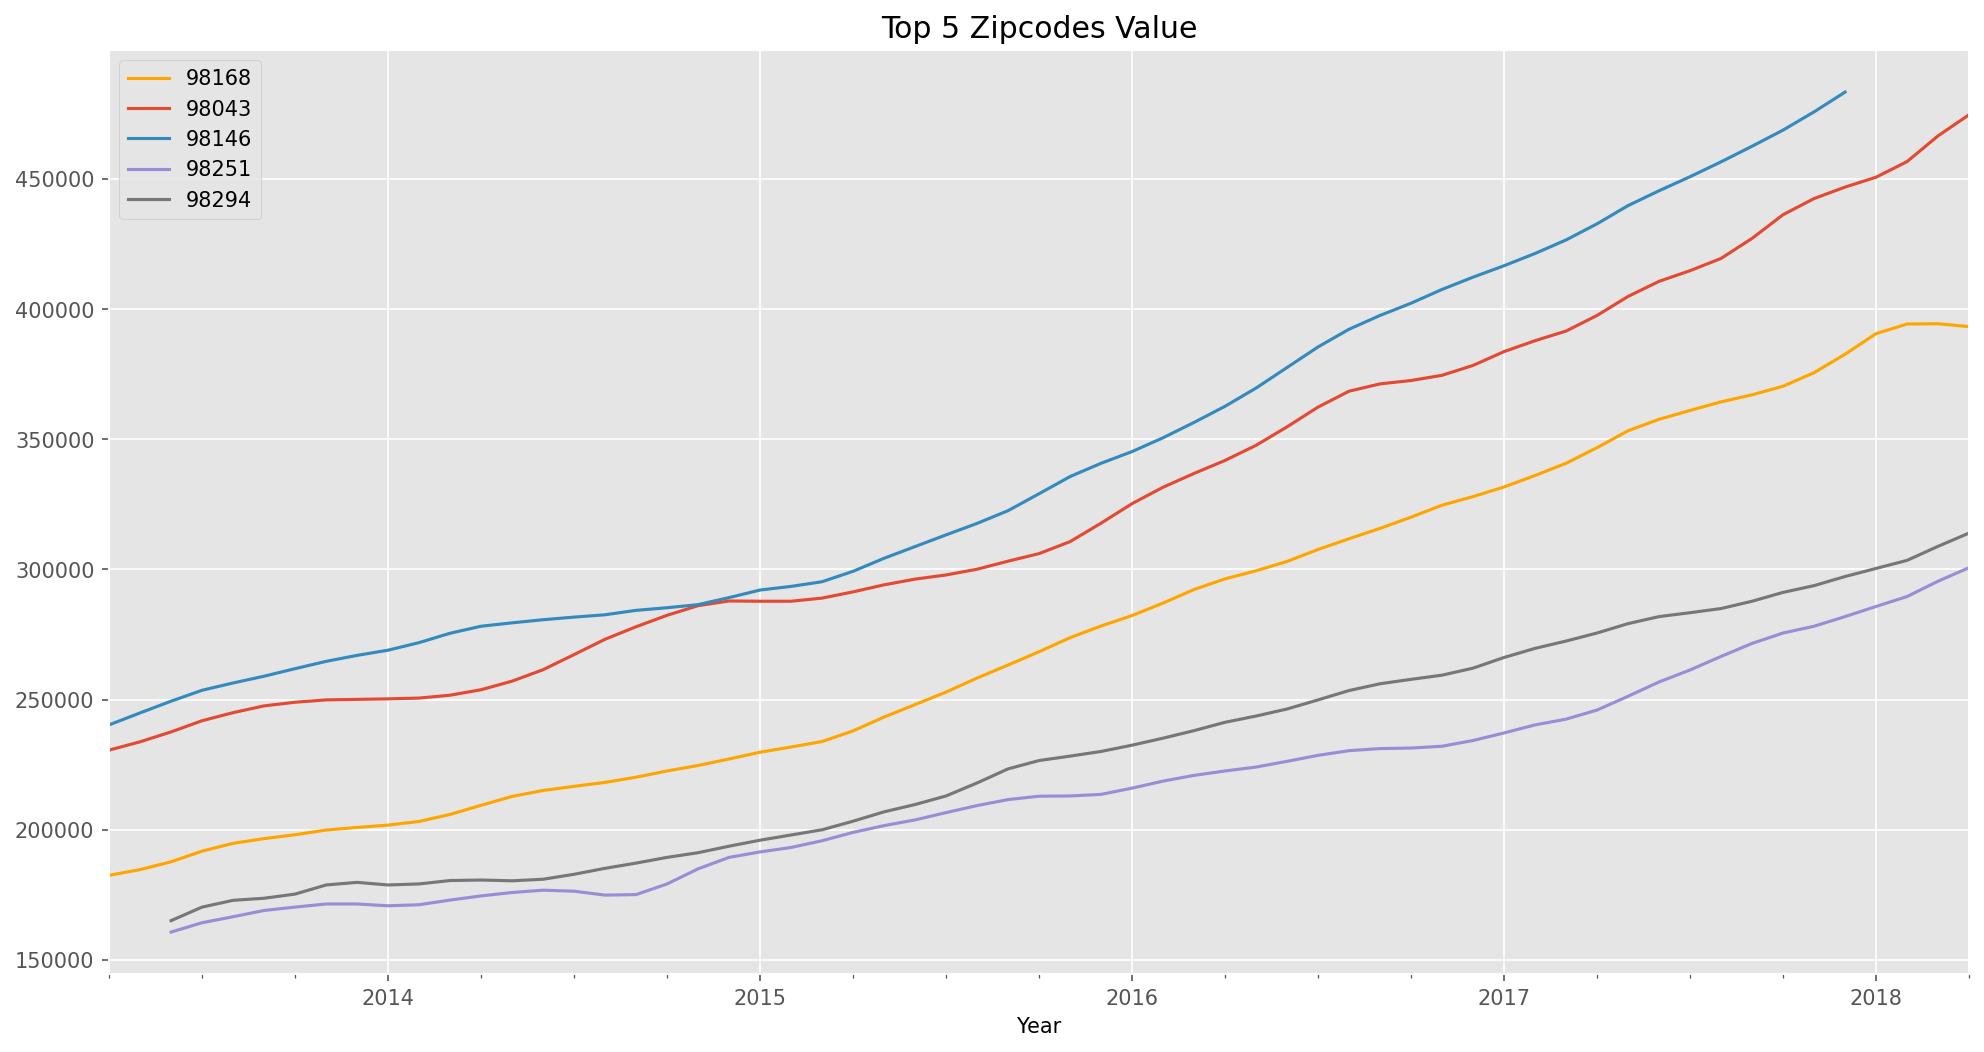

In [49]:
# Visualizing The Value of the Top Five Zip Codes
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot values.
# in plot method we set the label and color of the curve.
zip_98168['value'].plot(label='98168', color='orange')
zip_98043['value'].plot(label='98043')
zip_98146['value'].plot(label='98146')
zip_98251['value'].plot(label='98251')
zip_98294['value'].plot(label='98294')
  
# adding title to the plot
plt.title('Top 5 Zipcodes Value')
  
# adding label to the x-axis
plt.xlabel('Year')
  
# adding legend to the curve
plt.legend();

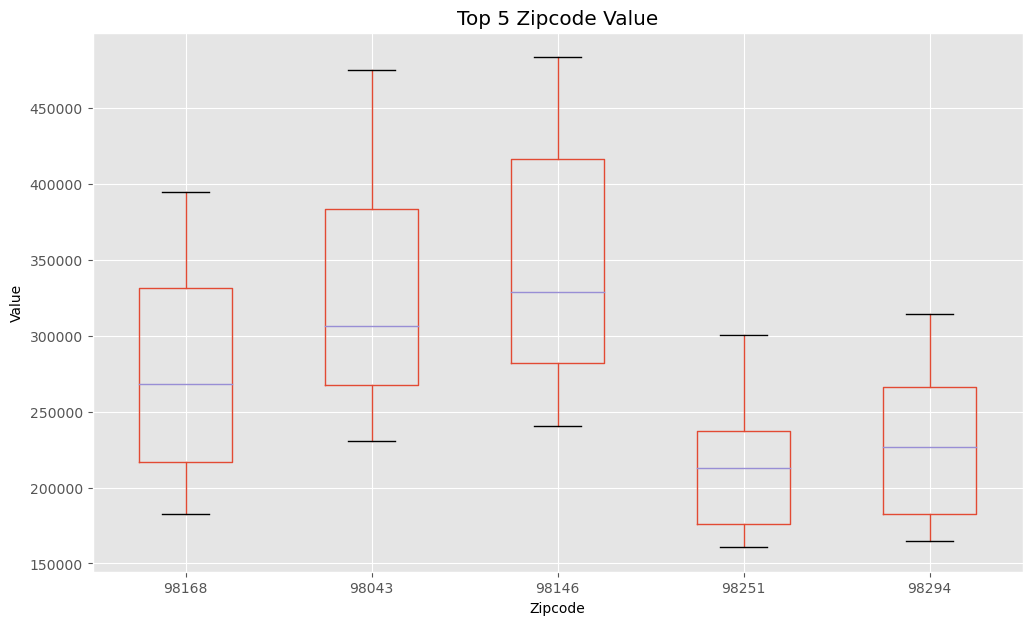

In [50]:
# Generate a box and whiskers plot for top 5 zipcodes
# Add titles 
box = zip_df.boxplot(figsize = (12,7,));
box.plot()
#adding title
plt.title('Top 5 Zipcode Value')
#adding xlabel 
plt.xlabel('Zipcode')
#adding ylabel
plt.ylabel('Value');

#### zip_98168
Let's take a look at zipcode 98168. The p-value is 0.94 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [51]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98168['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -0.167287
p-value                         0.942310
#Lags Used                      6.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [52]:
#differencing in order to remove trends
zip_98168_w = zip_98168.diff(periods=1)


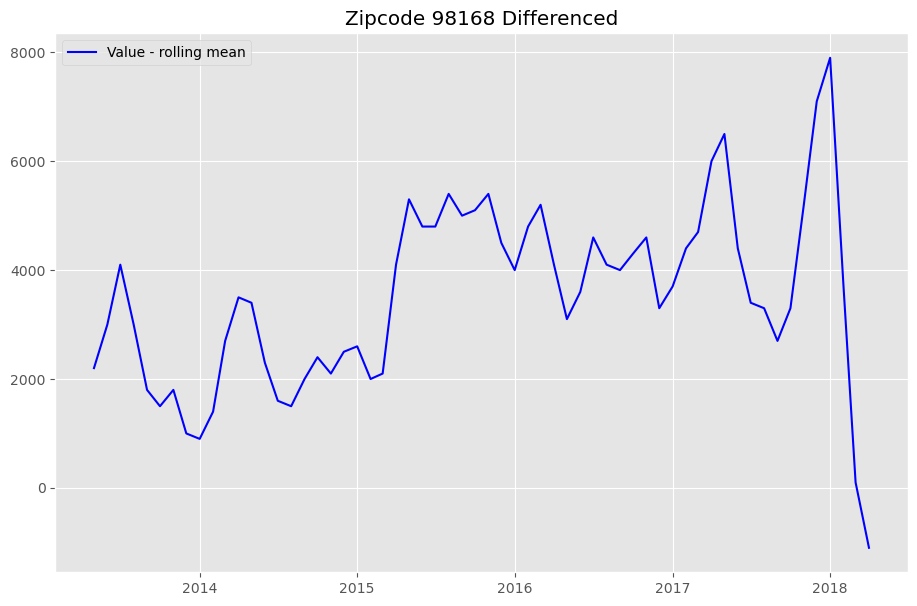

In [53]:
#plotting the differenced zipcode
fig = plt.figure(figsize=(11,7))
plt.plot(zip_98168_w, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Zipcode 98168 Differenced')
plt.show(block=False)

#### zip_98043
Let's take a look at zipcode 98043. The p-value is 0.99 which is not less than our critical value of -2.93, meaning the series is not stationary. 

In [54]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98043['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  2.842849
p-value                         1.000000
#Lags Used                      6.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [55]:
#differencing 
zip_98043_w = zip_98043.diff(periods=1)


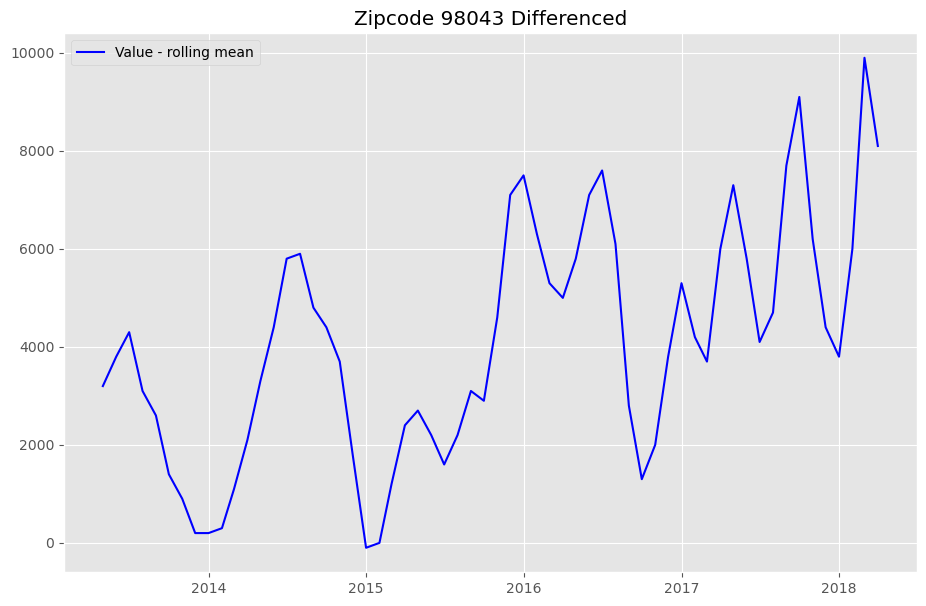

In [56]:
#Plotting the differenced Zipcode
fig = plt.figure(figsize=(11,7))
plt.plot(zip_98043_w, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Zipcode 98043 Differenced')
plt.show(block=False)

#### zip_98146
Let's take a look at zipcode 98146. The p-value is 0.99 which is not less than our critical value of -2.95, meaning the series is not stationary. 

In [57]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98146['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  2.340730
p-value                         0.998980
#Lags Used                     11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


In [58]:
#differencing
zip_98146_w = zip_98146.diff(periods=1)


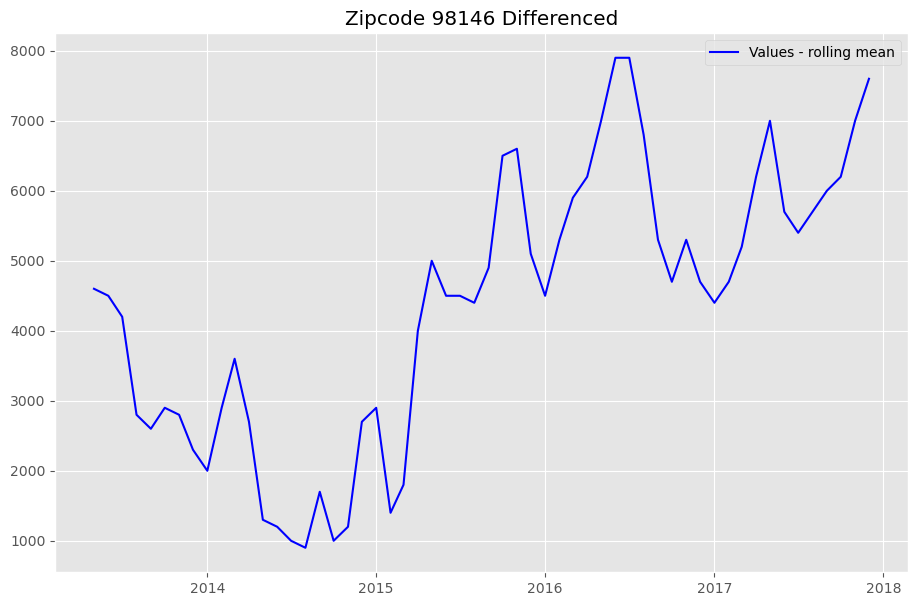

In [59]:
#plotting the differenced zipcode
fig = plt.figure(figsize=(11,7))
plt.plot(zip_98146_w, color='blue',label='Values - rolling mean')
plt.legend(loc='best')
plt.title('Zipcode 98146 Differenced')
plt.show(block=False)

#### zip_98251
Let's take a look at zipcode 98251. The p-value is 0.99 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [60]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98251['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  2.469807
p-value                         0.999039
#Lags Used                      3.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [61]:
#differencing
zip_98251_w = zip_98251.diff(periods=1)


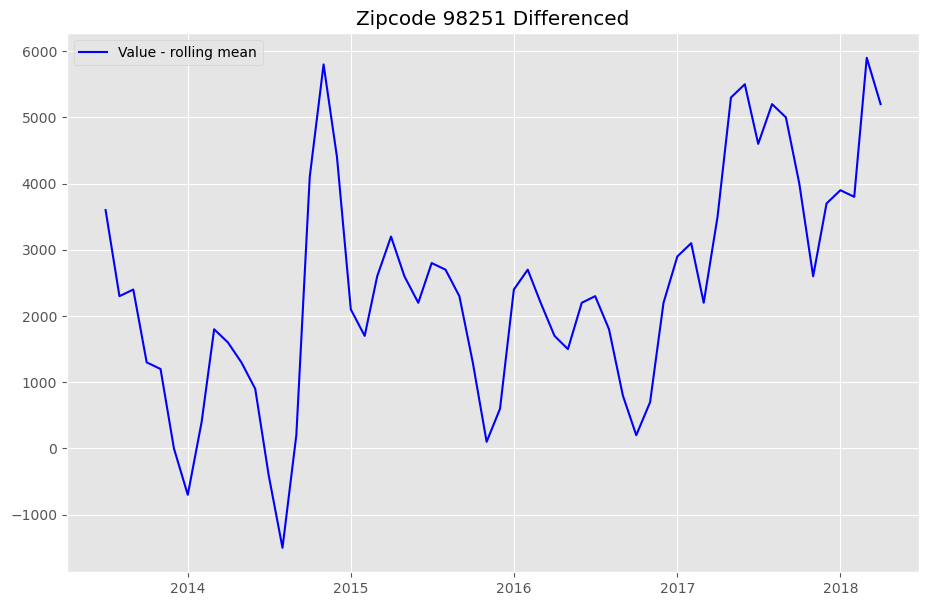

In [62]:
#plotting differenced zipcode
fig = plt.figure(figsize=(11,7))
plt.plot(zip_98251_w, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Zipcode 98251 Differenced')
plt.show(block=False)

#### zip_98294

Let's take a look at zipcode 98294. The p-value is 0.99 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [63]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98294['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  1.695794
p-value                         0.998118
#Lags Used                      3.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [64]:
#differencing
zip_98294_w = zip_98294.diff(periods=1)


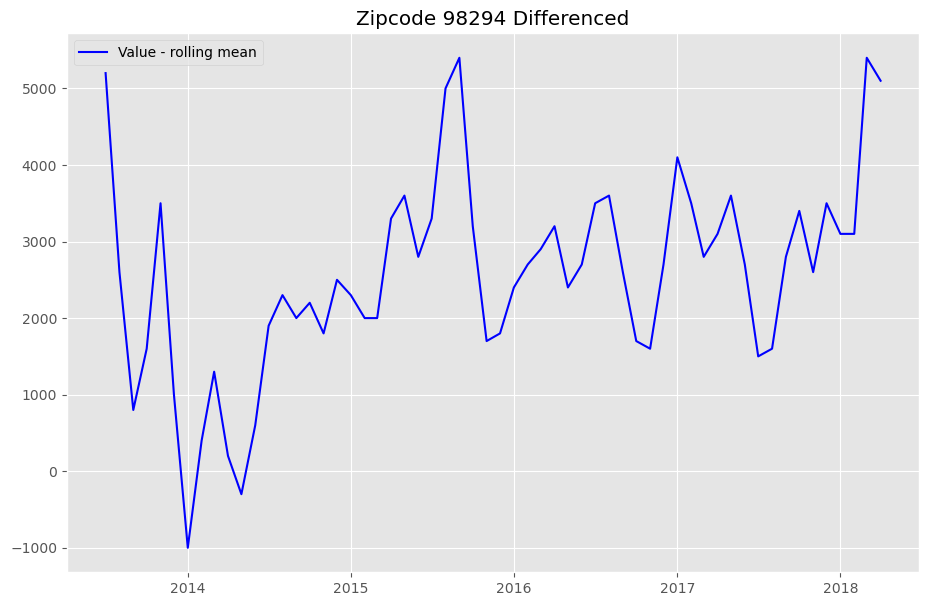

In [65]:
fig = plt.figure(figsize=(11,7))
plt.plot(zip_98294_w, color='blue',label='Value - rolling mean')
plt.legend(loc='best')
plt.title('Zipcode 98294 Differenced')
plt.show(block=False)

### Stationary Zip Code Analysis 

Now that we've differenced our top 5 zip codes and attempted to make them stationary, let's do some analysis. 


In [66]:
#combining all differenced zipcodes into one dataframe
zip_all_w = [zip_98168_w, zip_98043_w, zip_98146_w, zip_98251_w, zip_98294_w]
zip_names = ['98168', '98043', '98146', '98251', '98294']
zip_df_w = pd.concat(zip_all_w, axis = 1)
zip_df_w.columns = zip_names
zip_df_w.head()

98168   98043   98146   98251   98294
Date                                              
2013-04-01     NaN     NaN     NaN     NaN     NaN
2013-05-01  2200.0  3200.0  4600.0     NaN     NaN
2013-06-01  3000.0  3800.0  4500.0     NaN     NaN
2013-07-01  4100.0  4300.0  4200.0  3600.0  5200.0
2013-08-01  3000.0  3100.0  2800.0  2300.0  2600.0

In [67]:
# Perform filling of missing values
zip_df_w['98168'] = zip_df_w['98168'].ffill()
zip_df_w['98043'] = zip_df_w['98043'].ffill()
zip_df_w['98146'] = zip_df_w['98146'].ffill()
zip_df_w['98251'] = zip_df_w['98251'].ffill()
zip_df_w['98294'] = zip_df_w['98294'].ffill()
zip_df_w['98168'] = zip_df_w['98168'].bfill()
zip_df_w['98043'] = zip_df_w['98043'].bfill()
zip_df_w['98146'] = zip_df_w['98146'].bfill()
zip_df_w['98251'] = zip_df_w['98251'].bfill()
zip_df_w['98294'] = zip_df_w['98294'].bfill()
# Find the total number of missing values in the time series
zip_df_w.isna().sum()

98168    0
98043    0
98146    0
98251    0
98294    0
dtype: int64

In [68]:
#Perform filling of missing values 
zip_df_w = zip_df_w.ffill()
zip_df_w = zip_df_w.bfill()
zip_df_w.isna().sum()

98168    0
98043    0
98146    0
98251    0
98294    0
dtype: int64

In [69]:
#The zipcodes after being differenced are not as highly correlated
#This indicates that our time series is stationary 
zip_df_w.corr()

98168     98043     98146     98251     98294
98168  1.000000  0.111499  0.504227  0.107383  0.189697
98043  0.111499  1.000000  0.563806  0.388183  0.361385
98146  0.504227  0.563806  1.000000  0.395008  0.488919
98251  0.107383  0.388183  0.395008  1.000000  0.491030
98294  0.189697  0.361385  0.488919  0.491030  1.000000

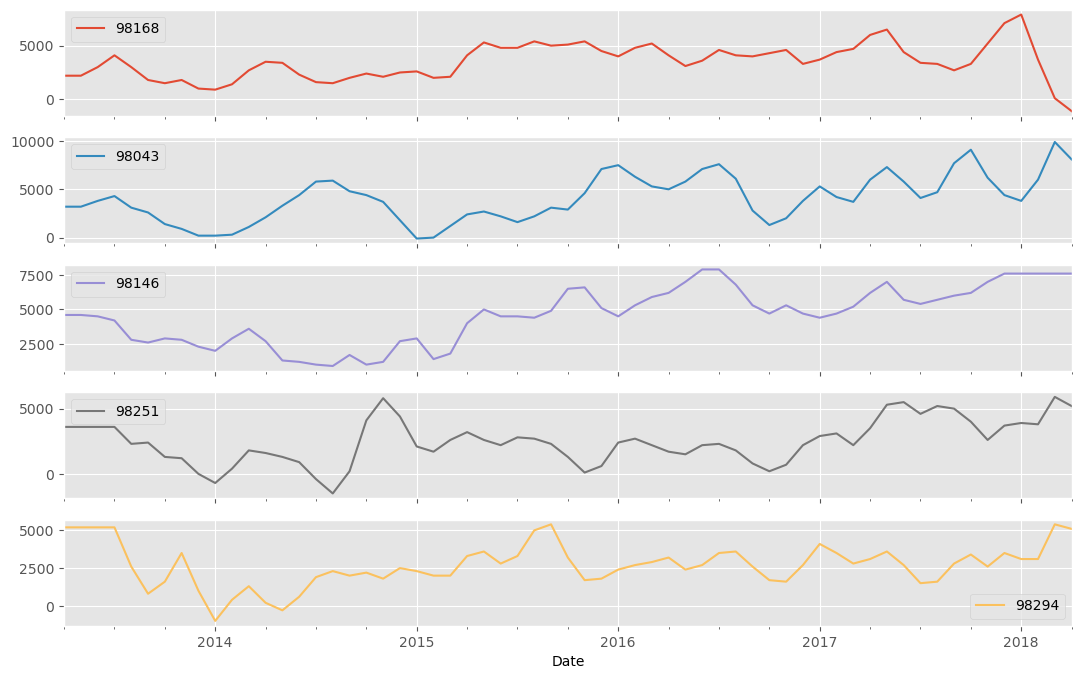

In [70]:
#Plotting the top 5 differenced zipcodes
zip_df_w.plot(figsize=(13,8), subplots=True, legend=True);

### ACF and PACF
ACF and PACF are tools we can use to help us find the order of AR, MA, and ARMA models. 

#### PACF
PACF, is a partial correlation, which can be explained by the amount of correlation between a variable and one lag of that variable which is not explained by lower order lags. 

The shaded area on the graph is our confidence interval. If the correlation drops into the confidence interval it means it is not statistically significant. 

#### ACF
ACF, is the correlation of the time series with a lagged version of itself. 

#### Results
- The ACF plot showed a strong correlation at 1 
- Geometric decay in ACF plot and PACF
- the PACF plot showed a strong correlation at 1 and 2 

This means that our time series could best be modeled using ARMA 
AR(p) = 2  
MA(q) = 1   


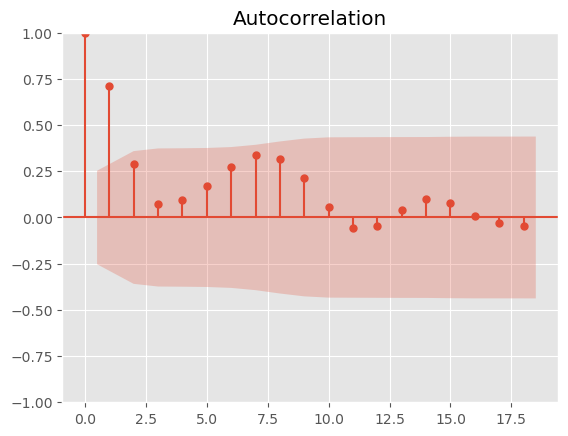

In [71]:
#plotting ACF 
#strong correlation at 1
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(zip_98168.diff().dropna());

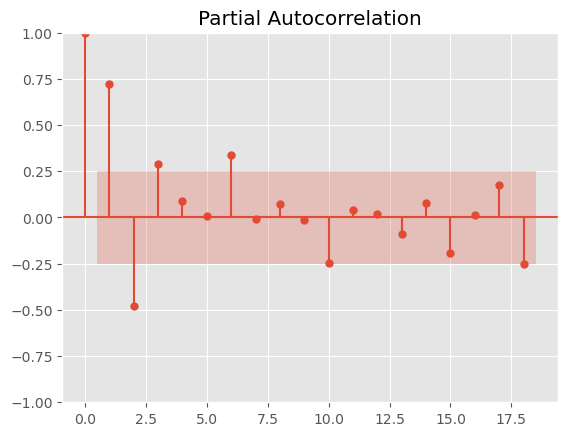

In [72]:
#Plotting PACF
#strong correlation at 2
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(zip_98168.diff().dropna());

## Modeling

### Train/Test Split

When doing a train/test split on a time series you cannot randomly split the data seeing as its time sensitive. Hence, in this case we will make our training data from our first 4 years of data and our testing data from our last year of data. 

In [73]:
#Creating training data based on 2013-04-01 to 2017-04-01
zip_train = zip_df_w['2013-04-01': '2017-04-01']
train = zip_98168_w[:'2017-04-01']
zip_98043_train = zip_98043_w[: '2017-04-01']
zip_98146_train = zip_98146_w[: '2017-04-01']
zip_98251_train = zip_98251_w[: '2017-04-01']
zip_98294_train = zip_98294_w[: '2017-04-01']

#Creating test data based on the last year of our
zip_test = zip_df_w['2017-04-01':]
valid = zip_98168_w['2017-04-01':]
zip_98043_test = zip_98043_w['2017-04-01':]
zip_98146_test = zip_98146_w['2017-04-01':]
zip_98251_test = zip_98251_w['2017-04-01':]
zip_98294_test = zip_98294_w['2017-04-01':]

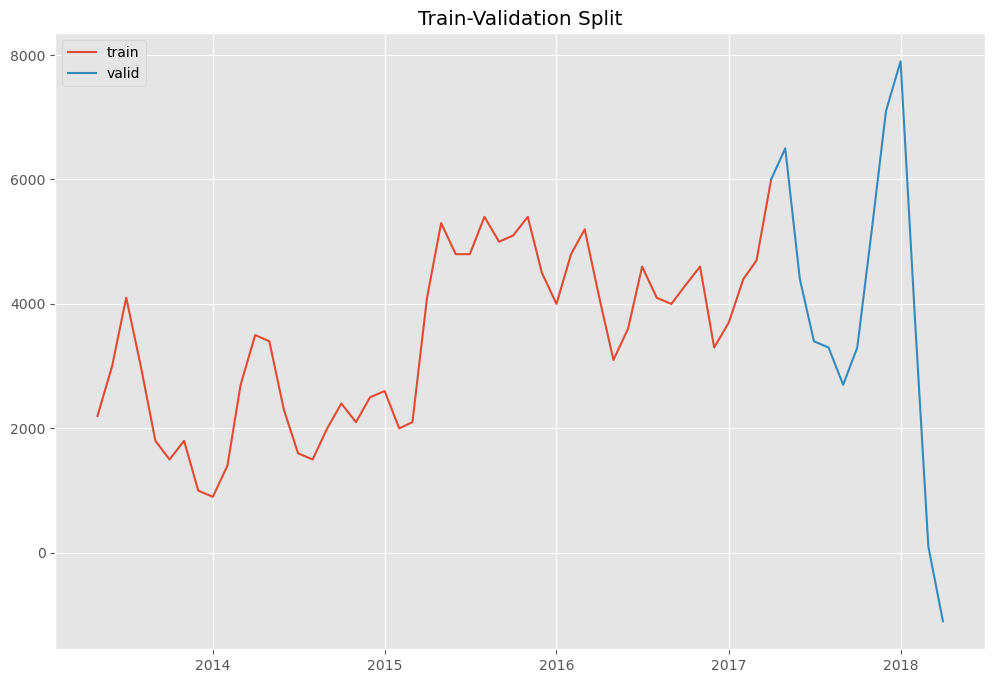

In [74]:
#observing the split
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
# ax.plot(valid)
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend();

### Baseline

In [75]:
#Building a baseline model using our train set
#filling any missing values 
train = train.bfill()


In [76]:
# we can perform this with the shift operator
# The prediction for the next month is the original series shifted to the future by one month.
naive = train.shift(1)


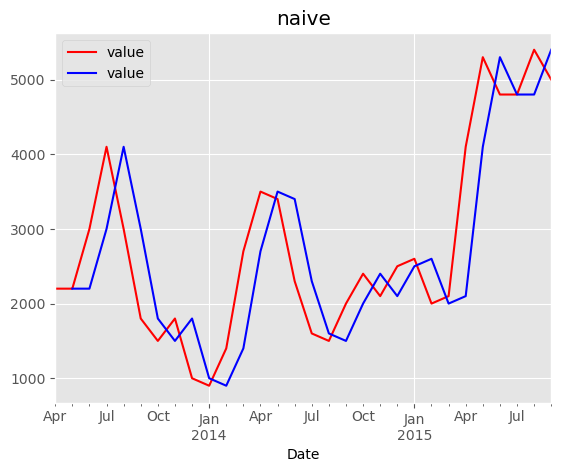

In [77]:
# visualizing the shift
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

#### RMSE

Root mean square error (RMSE) is a commonly used measure for evaluating the quality of a model's prediction. It shows how far a prediction is from the measured true value by using Euclidean distance. 

The RMSE is computed for the naive model to compare against our later models. 

In [78]:
#obtaining RMSE
from sklearn.metrics import mean_squared_error
naive_RMSE = np.sqrt(mean_squared_error(train[1:], naive.dropna()))
naive_RMSE

748.0530284233421

### The Autoregressive Model (AR)

This model is a creation of two simpler models. It takes in three values for it's order: 

- p: represents the AR term
- d: represents the differencing order 
- q: represents the lagged error


In [79]:
#AR model with order of 1, 1, 0
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

2013-04-01       0.000000
2013-05-01    2368.976866
2013-06-01    2200.000000
2013-07-01    3169.031916
2013-08-01    4332.418885
2013-09-01    2767.581115
2013-10-01    1546.452125
2013-11-01    1436.613031
2013-12-01    1863.386969
2014-01-01     830.968084
2014-02-01     878.871010
2014-03-01    1505.644948
2014-04-01    2974.676864
2014-05-01    3669.031916
2014-06-01    3378.871010
2014-07-01    2067.581115
2014-08-01    1452.097073
2014-09-01    1478.871010
2014-10-01    2105.644948
2014-11-01    2484.515958
2014-12-01    2036.613031
2015-01-01    2584.515958
2015-02-01    2621.128990
2015-03-01    1873.226063
2015-04-01    2121.128990
2015-05-01    4522.579791
2015-06-01    5553.547875
2015-07-01    4694.355052
2015-08-01    4800.000000
2015-09-01    5526.773937
2015-10-01    4915.484042
2015-11-01    5121.128990
2015-12-01    5463.386969
2016-01-01    4309.839094
2016-02-01    3894.355052
2016-03-01    4969.031916
2016-04-01    5284.515958
2016-05-01    3867.581115
2016-06-01  

In [80]:
#pulling up summary
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -384.684
Date:                Wed, 12 Apr 2023   AIC                            773.368
Time:                        16:38:22   BIC                            777.110
Sample:                    04-01-2013   HQIC                           774.782
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2113      0.156      1.357      0.175      -0.094       0.516
sigma2      5.456e+05   1.23e+05      4.428      0.000    3.04e+05    7.87e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.49   Prob(JB):                         0.91
Heteroskedasticity (H):               1.07   Skew:                            -0.03
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### AIC 
The Akaiki information criterion (AIC) is an estimator of prediction error. A lower AIC generally indicates a better model. AIC will be used to compare our models. 

In [81]:
#AIC for our ar_1 model
ar_1.aic

773.3676975227331

### Random Walk Model 

In [82]:
#Random walk model and summary
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -385.748
Date:                Wed, 12 Apr 2023   AIC                            773.496
Time:                        16:38:23   BIC                            775.367
Sample:                    04-01-2013   HQIC                           774.203
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.593e+05   1.25e+05      4.482      0.000    3.15e+05    8.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.05   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.15   Prob(JB):                         0.84
Heteroskedasticity (H):               0.94   Skew:                             0.09
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
#comparing AIC
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 773.4955955184494
AR(1, 1, 0) AIC: 773.3676975227331


In [84]:
#Getting RMSE
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

789.1530181506056

### AR Model 

In [85]:
#AR model with order of 2, 1, 0
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

2013-04-01       0.000000
2013-05-01    2365.107654
2013-06-01    1857.072377
2013-07-01    3246.289292
2013-08-01    4075.989344
2013-09-01    2162.696881
2013-10-01    1929.221406
2013-11-01    1951.629163
2013-12-01    2028.355396
2014-01-01     617.713797
2014-02-01    1231.872270
2014-03-01    1599.263111
2014-04-01    2873.558579
2014-05-01    3156.969340
2014-06-01    3006.555407
2014-07-01    2006.684528
2014-08-01    1883.152213
2014-09-01    1786.539966
2014-10-01    2199.263111
2014-11-01    2296.483126
2014-12-01    1826.312300
2015-01-01    2759.141558
2015-02-01    2449.456946
2015-03-01    1769.950727
2015-04-01    2402.779985
2015-05-01    4670.390925
2015-06-01    4762.787858
2015-07-01    4102.081545
2015-08-01    5026.661520
2015-09-01    5584.716969
2015-10-01    4604.861530
2015-11-01    5312.115377
2015-12-01    5447.026180
2016-01-01    4086.927635
2016-02-01    4254.059928
2016-03-01    5272.950811
2016-04-01    4960.486214
2016-05-01    3580.023008
2016-06-01  

In [86]:
#comparing AIC
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

773.4955955184494
773.3676975227331
764.5479468177364


In [87]:
#obtaining RMSE
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

719.4834299538893

### Moving Average Model (MA)

This model is based on error. It makes predictions based on how far off the data was in the previous point of time. 

In [88]:
#moving average model with order of 0, 0, 1
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

2013-04-01    3403.859764
2013-05-01    2804.974424
2013-06-01    3003.928591
2013-07-01    3400.947747
2013-08-01    3954.758600
2013-09-01    2622.616818
2013-10-01    2713.690027
2013-11-01    2367.558041
2013-12-01    2913.029976
2014-01-01    1733.612728
2014-02-01    2670.741122
2014-03-01    2280.026016
2014-04-01    3776.912981
2014-05-01    3157.032638
2014-06-01    3621.024738
2014-07-01    2220.532112
2014-08-01    2847.030289
2014-09-01    2193.400121
2014-10-01    3229.868982
2014-11-01    2656.584045
2014-12-01    2902.293987
2015-01-01    3041.111584
2015-02-01    3005.912747
2015-03-01    2496.013839
2015-04-01    3046.336115
2015-05-01    4355.368341
2015-06-01    4257.093208
2015-07-01    3894.324692
2015-08-01    4222.170602
2015-09-01    4468.198022
2015-10-01    3884.465878
2015-11-01    4502.462935
2015-12-01    4215.108710
2016-01-01    3661.375545
2016-02-01    3709.958633
2016-03-01    4389.235106
2016-04-01    4136.795931
2016-05-01    3370.595246
2016-06-01  

In [89]:
#pulling up summary
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -400.121
Date:                Wed, 12 Apr 2023   AIC                            806.243
Time:                        16:38:23   BIC                            811.918
Sample:                    04-01-2013   HQIC                           808.396
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3403.8598    231.271     14.718      0.000    2950.577    3857.142
ma.L1          0.9041      0.080     11.350      0.000       0.748       1.060
sigma2          7e+05   2.05e+05      3.420      0.001    2.99e+05     1.1e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.08   Jarque-Bera (JB):                 2.31
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               0.77   Skew:                            -0.16
Prob(H) (two-sided):                  0.61   Kurtosis:                         1.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
#comparing AIC
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

773.4955955184494
773.3676975227331
764.5479468177364
806.2428581517993


In [91]:
#Obtain RMSE
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

852.0466017164532

#### MA 2

In [92]:
#moving average model with order 0, 1, 2
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2013-04-01       0.000000
2013-05-01    2303.446040
2013-06-01    1967.740137
2013-07-01    3234.791355
2013-08-01    3975.616373
2013-09-01    2472.895602
2013-10-01    1965.443280
2013-11-01    1615.204106
2013-12-01    2009.577222
2014-01-01     675.456526
2014-02-01    1311.628823
2014-03-01    1344.105514
2014-04-01    3019.725242
2014-05-01    3148.484123
2014-06-01    3296.542512
2014-07-01    1953.753752
2014-08-01    1858.210078
2014-09-01    1531.435205
2014-10-01    2247.045341
2014-11-01    2275.124725
2014-12-01    2000.970744
2015-01-01    2690.669788
2015-02-01    2401.356473
2015-03-01    1927.916377
2015-04-01    2285.436500
2015-05-01    4509.383099
2015-06-01    4867.740712
2015-07-01    4504.939290
2015-08-01    4900.169206
2015-09-01    5425.833175
2015-10-01    4714.301493
2015-11-01    5349.333014
2015-12-01    5277.729531
2016-01-01    4280.861693
2016-02-01    4200.284291
2016-03-01    5053.853825
2016-04-01    5027.324540
2016-05-01    3808.616588
2016-06-01  

In [93]:
#pulling up summary
ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -380.009
Date:                Wed, 12 Apr 2023   AIC                            766.018
Time:                        16:38:23   BIC                            771.632
Sample:                    04-01-2013   HQIC                           768.139
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2589      0.139      1.863      0.062      -0.013       0.531
ma.L2         -0.3510      0.181     -1.943      0.052      -0.705       0.003
sigma2      4.196e+05   8.27e+04      5.072      0.000    2.57e+05    5.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.61   Prob(JB):                         0.98
Heteroskedasticity (H):               0.94   Skew:                             0.07
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
#comparing AIC
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

773.4955955184494
773.3676975227331
764.5479468177364
806.2428581517993
766.0180561743471


In [95]:
#obtaining RMSE
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

728.2864518752566

### ARMA

Let's combine our AR and MA values to fine tune our model. Our best performing AR model had an order of 2, 1, 0 and our best performing MA model had an order 0, 1, 2. This is line with the result of our ACF and PACF plots from previously. 

In [96]:
#ARMA model with order of 2, 1, 2
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

#pulling up summary
arma_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -374.370
Date:                Wed, 12 Apr 2023   AIC                            758.741
Time:                        16:38:23   BIC                            768.097
Sample:                    04-01-2013   HQIC                           762.276
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6223      0.146     -4.276      0.000      -0.908      -0.337
ar.L2         -0.7139      0.124     -5.777      0.000      -0.956      -0.472
ma.L1          1.3020      1.274      1.022      0.307      -1.194       3.798
ma.L2          0.9969      1.954      0.510      0.610      -2.832       4.826
sigma2       3.07e+05   5.96e+05      0.515      0.606    -8.6e+05    1.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.89   Prob(JB):                         0.57
Heteroskedasticity (H):               1.28   Skew:                             0.09
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
#Comparing AIC
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

773.4955955184494
773.3676975227331
764.5479468177364
806.2428581517993
766.0180561743471
758.740697905051


### Auto ARIMA

According to our AIC our best model so far is an ARMA model with order of 2, 1, 2. 

However, let's use an Auto ARIMA model, which automatically searches for the best parameters and model to use. 

According to our Auto ARIMA results a SARIMAX model with order 0, 1, 3 and seasonal order of 0, 0, 0, 0 should be tried. 

In [98]:
# In order for this cell to run, you may need to install pmdarima if you haven't already.
import pmdarima as pm
auto_model = pm.auto_arima(train, start_p=0, start_q=0)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -376.911
Date:                Wed, 12 Apr 2023   AIC                            761.822
Time:                        16:38:24   BIC                            769.307
Sample:                             0   HQIC                           764.651
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5211      0.185      2.822      0.005       0.159       0.883
ma.L2         -0.3987      0.178     -2.244      0.025      -0.747      -0.051
ma.L3         -0.5223      0.138     -3.774      0.000      -0.794      -0.251
sigma2      3.725e+05   7.35e+04      5.070      0.000    2.28e+05    5.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.60   Prob(JB):                         0.83
Heteroskedasticity (H):               1.47   Skew:                             0.21
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
#finding order
auto_model.order

(0, 1, 3)

In [100]:
#finding seasonal order
auto_model.seasonal_order

(0, 0, 0, 0)

### Sarimax

In [101]:
#SARIMAX model with order of 0, 1, 3
sari_mod =SARIMAX(train,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()
sari_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -344.249
Date:                Wed, 12 Apr 2023   AIC                            696.498
Time:                        16:38:24   BIC                            703.635
Sample:                    04-01-2013   HQIC                           699.145
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5459      0.193      2.833      0.005       0.168       0.923
ma.L2         -0.3636      0.218     -1.667      0.096      -0.791       0.064
ma.L3         -0.5139      0.155     -3.323      0.001      -0.817      -0.211
sigma2      3.725e+05   7.49e+04      4.972      0.000    2.26e+05    5.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.69   Prob(JB):                         0.56
Heteroskedasticity (H):               2.49   Skew:                             0.37
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Comparing Models
Let's find the best model by the RMSE of training and test data. The model with the best RMSE for training was the ARMA 21 model with a value of 665, the SARIMAX model had a value of 697.

The model with the best testing RMSE  was the SARIMAX model with a value of 2887. 

Since, the SARIMAX model performed better on our testing data this is the model we will use to forecast our time series. 

In [102]:
#Finding RMSE
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [103]:
#compare RMSE of training data
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))
print(find_rmse(sari_mod))

804.3250434433855
789.1530181506056
719.4834299538893
852.0466017164532
728.2864518752566
665.7037338952215
697.0174695153429


In [104]:
#compare RMSE of testing data
def find_rmse_test(model, test_data=valid):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [105]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))
print(find_rmse_test(sari_mod))

3194.9479350518855
3416.0085509530472
3023.8846225127754
2405.197920753284
2995.382779587026
3612.2246646728277
2887.381390559421


### Best Model: SARIMAX

Our SARIMAX model with an order of 0, 1, 3 and seasonal order of 0, 0, 0, 0 performed the best on our testing data. 


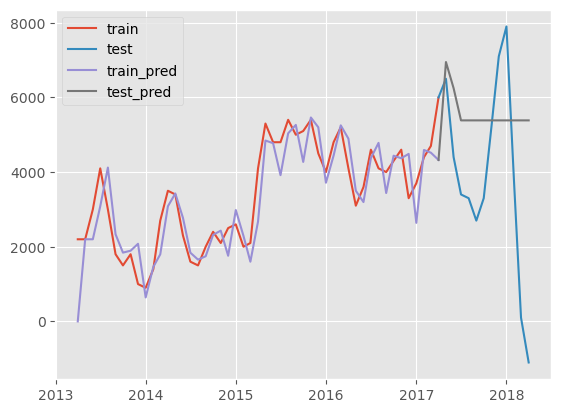

In [106]:
#visualizing observed versus preducted data
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=valid.index[0], end=valid.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(valid, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

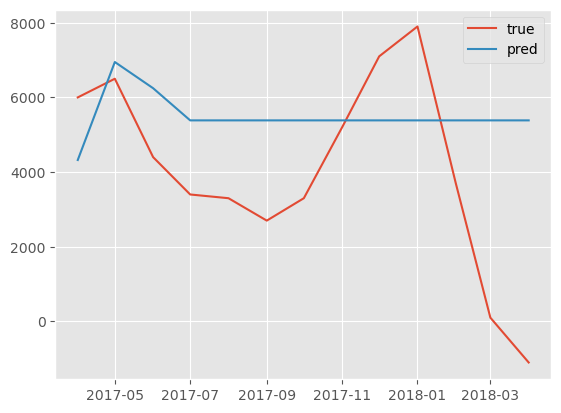

In [107]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(valid, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

## Data Interpretation

### Forecasting Each Zip

The best model will be fit to each of our top 5 zip codes. Which will be used to forecast home prices for the next year. ROI will be calculated using the average forecast value versus the average house value for the last year of our data. 

#### 98168

In [108]:
#fitting best model
sari_mod =SARIMAX(zip_98168_w,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [109]:
#getting forecast for 1 year out
from sklearn import metrics
forecast = sari_mod.forecast(steps=12)

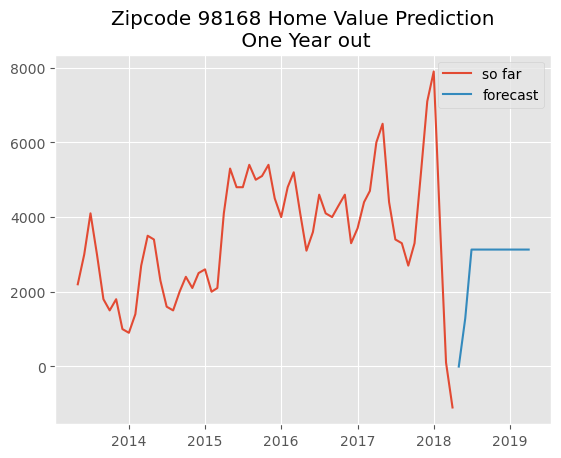

In [110]:
# visualizing forecast
fig, ax = plt.subplots()
ax.plot(zip_98168_w, label='so far')
ax.plot(forecast, label='forecast')
ax.set_title('Zipcode 98168 Home Value Prediction\n One Year out')

plt.legend();

In [111]:
#Getting yearly average for forecast
y_pred = forecast.mean()
print(y_pred)

2715.05804520863


In [112]:
#Getting yearly average of last year of data 
y = zip_98168_w.tail(12).mean()
print(y)

value    3875.0
dtype: float64


In [113]:
#Finding ROI
ROI = []
ROI_98168 = ((y_pred - y)/y)*100
print(ROI_98168)

value   -29.933986
dtype: float64


#### 98043

In [114]:
#fitting model 
sari_mod =SARIMAX(zip_98043_w,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [115]:
#getting forecast for next year 
forecast = sari_mod.forecast(steps=12)

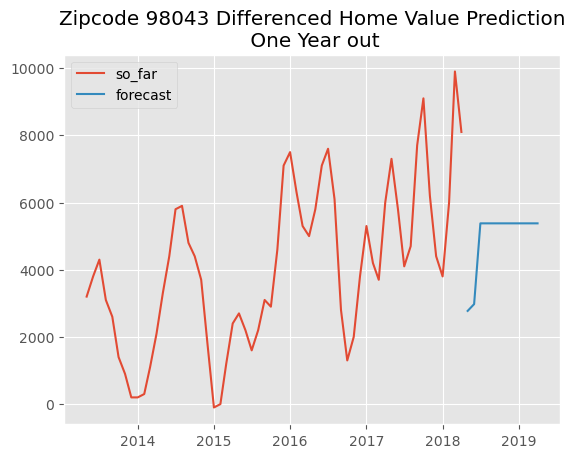

In [116]:
#visualizing forecast
fig, ax = plt.subplots()
ax.plot(zip_98043_w, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Zipcode 98043 Differenced Home Value Prediction\n One Year out')

plt.legend();

In [117]:
#taking average of yearly forecast
y_pred = forecast.mean()
print(y_pred)

4962.463316569482


In [118]:
#taking average of last year of observed data 
y = zip_98043_w.tail(12).mean()
print(y)

value    6425.0
dtype: float64


In [119]:
#finding ROI
ROI_98043 = ((y_pred - y)/y)*100
ROI.append(ROI_98043)
print(ROI_98043)

value   -22.763217
dtype: float64


#### 98146

In [120]:
#fitting model 
sari_mod =SARIMAX(zip_98146_w,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [121]:
#getting forecast for next year 
forecast = sari_mod.forecast(steps=12)

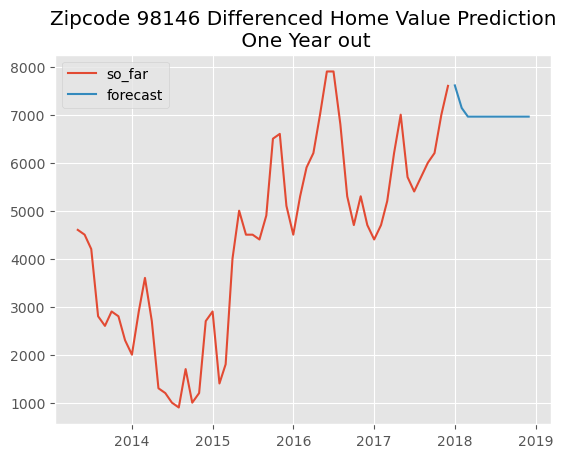

In [122]:
#visualizing forecast
fig, ax = plt.subplots()
ax.plot(zip_98146_w, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Zipcode 98146 Differenced Home Value Prediction\n One Year out')

plt.legend();

In [123]:
#taking forecast average
y_pred = forecast.mean()
print(y_pred)

7028.837255231359


In [124]:
#taking last year average
y = zip_98146_w.tail(12).mean()
print(y)

value    5925.0
dtype: float64


In [125]:
#finding ROI
ROI_98146 = ((y_pred - y)/y)*100
print(ROI_98146)

value    18.630165
dtype: float64


#### 98251

In [126]:
#fitting model 
sari_mod =SARIMAX(zip_98251_w,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [127]:
#getting forecast for next year
forecast = sari_mod.forecast(steps=12)

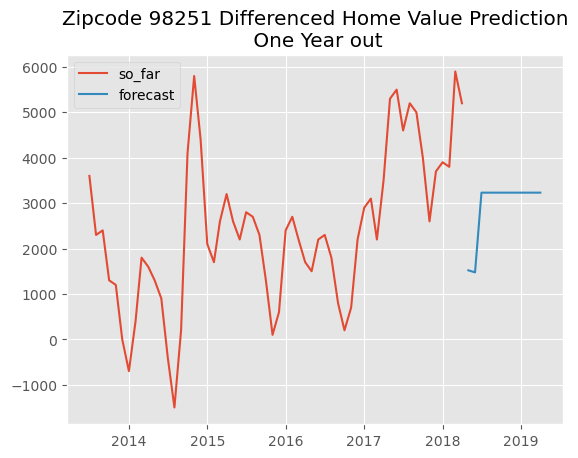

In [128]:
#visualizing forecast
fig, ax = plt.subplots()
ax.plot(zip_98251_w, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Zipcode 98251 Differenced Home Value Prediction\n One Year out')

plt.legend();

In [129]:
#getting average forecast
y_pred = forecast.mean()
print(y_pred)

2942.420583156329


In [130]:
#getting average of last year of data 
y = zip_98251_w.tail(12).mean()
print(y)

value    4558.333333
dtype: float64


In [131]:
#finding ROI
ROI_98251 = ((y_pred - y)/y)*100
print(ROI_98251)

value   -35.44964
dtype: float64


#### 98294

In [132]:
#fitting model
sari_mod =SARIMAX(zip_98294_w,
                  order=(0, 1, 3),
                  seasonal_order=(0, 0, 0, 0),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [133]:
#getting forecast
forecast = sari_mod.forecast(steps=12)

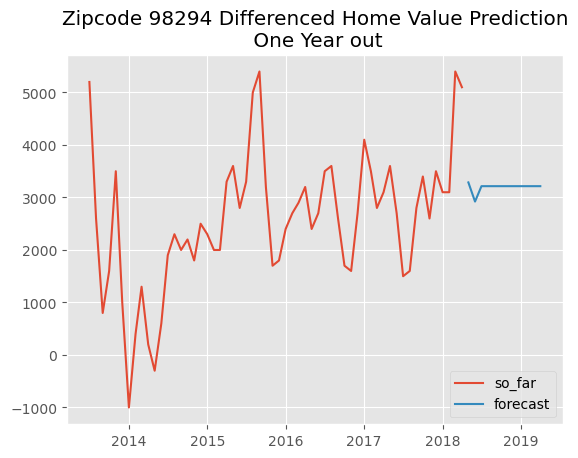

In [134]:
#visualizing forecast
fig, ax = plt.subplots()
ax.plot(zip_98294_w, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Zipcode 98294 Differenced Home Value Prediction\n One Year out')

plt.legend();

In [135]:
#getting forecast average
y_pred = forecast.mean()
print(y_pred)

3196.9371981329573


In [136]:
#getting last year average
y = zip_98294_w.tail(12).mean()
print(y)

value    3200.0
dtype: float64


In [137]:
#finding ROI
ROI_98294 = ((y_pred - y)/y)*100
print(ROI_98294)

value   -0.095713
dtype: float64


### Predicted ROI of The Top Five Zip Codes   
Zip Code	Predicted ROI  
98146	18.630165   
98294	-0.095713    
98043	-22.763217     
98168	-29.933986     
98251	-35.449640    

In [140]:
#Making a table for the ROI values
#.to_string(index=False)
lst1 = ['98168', '98043', '98146', '98251', '98294']
lst2 = [ROI_98168, ROI_98043, ROI_98146, ROI_98251, ROI_98294]
ROI_df = pd.DataFrame(list(zip(lst1, lst2)), columns =['Zipcode', 'Predicted ROI'])
ROI_df = ROI_df.astype({'Zipcode': 'string', 'Predicted ROI':'float'})
ROI_df_sort = ROI_df.sort_values('Predicted ROI',ascending=False).head()[['Zipcode','Predicted ROI']]
ROI_df_sort

Zipcode  Predicted ROI
2   98146      18.630165
4   98294      -0.095713
1   98043     -22.763217
0   98168     -29.933986
3   98251     -35.449640

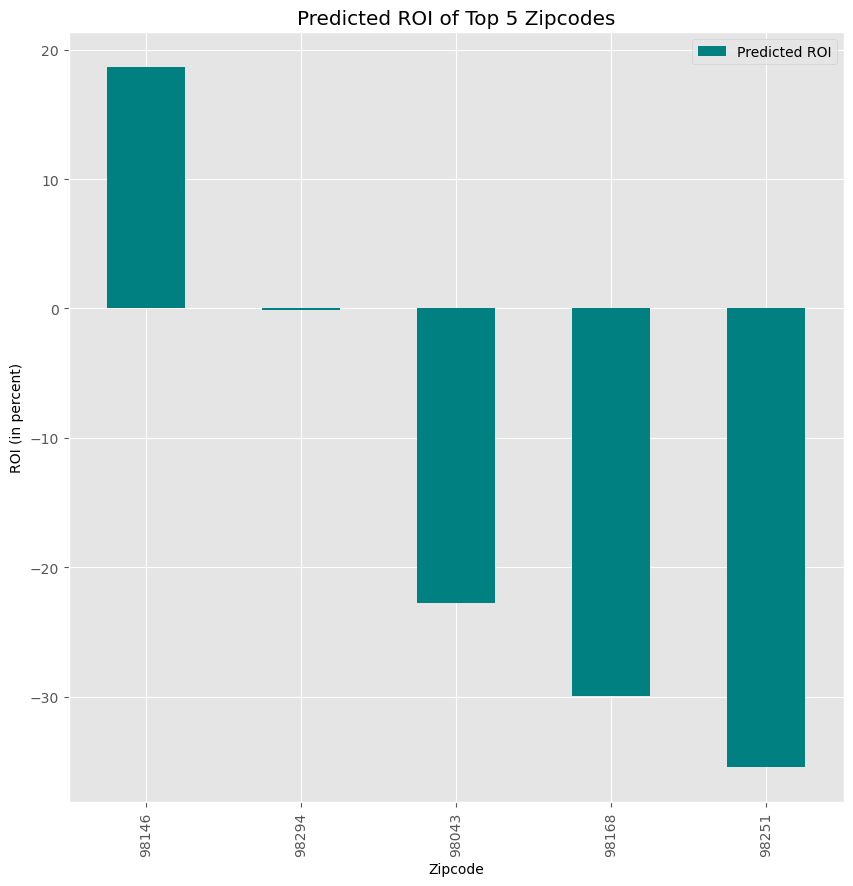

In [141]:
#Visualizing predicted ROI
ROI_df_sort.plot(figsize= (10, 10), color = 'teal', x = 'Zipcode', y= 'Predicted ROI', kind='bar', title='Predicted ROI of Top 5 Zipcodes', ylabel = 'ROI (in percent)', xlabel = 'Zipcode');

## Recommendations and Conclusion

Steady, our client, wants to know which zipcode they should look at in Washington to develop their next housing community. 

The top three zip codes we recommend Steady to invest in are:

1. 98146, Seattle, WA which has a predicted 1 year ROI of 18.63%   
2. 98294, Sultan, WA which has a predicted 1 year ROI of -0.09%
3. 98043, Mountlake Terrace, WA which has a predicted 1 year ROI of -22.76%
 

### Future Work 
In the future it would be great to have more recent data to work with. This data is limited due to the housing market crash of 2008. It would be interesting to see what this data looks like once we have some distance from the crash. 


## For More Information
Thank you for looking at this project. If you have any further questions please contact Salome "Sam" Grasland at sam.grasland@gmail.com


## Repository Structure
├── README.md <- The top-level README for reviewers of this project    
├── Phase 4 Notebook.ipynb <- Narrative documentation of analysis in Jupyter notebook   
├── Phase 4 Project Presentation.pdf <- PDF version of project presentation   
├── data <- Both sourced externally and generated from code    
└── images <- Both sourced externally and generated from code    